# 자전거 렌탈 데이터 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 읽어오기

In [2]:
train_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\test.csv')

## 데이터 살펴보기
- 데이터가 아닌 것 : 'datetime'
- 숫자 데이터 : 'temp',, 'humidity', 'windspeed'
- 카테고리 데이터  'season', 'holiday', 'workingday', 'weather':

In [3]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

## 결측 데이터 체크

In [4]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Feature Engineering
- 데이터가 아닌 것에서 데이터 추출
- 스케일링
- 인코딩

In [9]:
# 데이터가 아닌 것에서 데이터 추출
train_df['year'] = pd.to_datetime( train_df['datetime'] ).dt.year
train_df['month'] = pd.to_datetime( train_df['datetime'] ).dt.month
train_df['hour'] = pd.to_datetime( train_df['datetime'] ).dt.hour
train_df['sin_hour'] = np.sin( (train_df['hour']/24) * 2 * np.pi )
train_df['cos_hour'] = np.cos( (train_df['hour']/24) * 2 * np.pi )
train_df['sin_month'] = np.sin( (train_df['month']/12) * 2 * np.pi )
train_df['cos_month'] = np.cos( (train_df['month']/12) * 2 * np.pi )

test_df['year'] = pd.to_datetime( test_df['datetime'] ).dt.year
test_df['month'] = pd.to_datetime( test_df['datetime'] ).dt.month
test_df['hour'] = pd.to_datetime( test_df['datetime'] ).dt.hour
test_df['sin_hour'] = np.sin( (test_df['hour']/24) * 2 * np.pi )
test_df['cos_hour'] = np.cos( (test_df['hour']/24) * 2 * np.pi )
test_df['sin_month'] = np.sin( (test_df['month']/12) * 2 * np.pi )
test_df['cos_month'] = np.cos( (test_df['month']/12) * 2 * np.pi )

In [18]:
# 스케일링
from sklearn.preprocessing import StandardScaler
num_features = ['temp', 'humidity', 'windspeed', 
                'sin_hour', 'cos_hour', 'sin_month', 'cos_month']

sc = StandardScaler()
sc.fit( train_df[num_features]  )
X = pd.DataFrame( sc.transform( train_df[num_features] ), columns=num_features )
test_X = pd.DataFrame( sc.transform( test_df[num_features] ), columns=num_features )

In [24]:
# 인코딩
from sklearn.preprocessing import OneHotEncoder

cate_features = ['season', 'holiday', 'workingday', 'weather','year']
one_hot = OneHotEncoder(sparse_output=False, drop='first')
one_hot.fit(train_df[cate_features])
X[one_hot.get_feature_names_out()] = one_hot.transform( train_df[cate_features] )
test_X[one_hot.get_feature_names_out()] = one_hot.transform( test_df[cate_features] )

## 훈련용 데이터와 검증용 데이터로 나누기

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV

y = train_df['count']
y2 = train_df[['casual', 'registered',]]

In [31]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.3, 
                                                      random_state=18)

## 하이퍼 파라미터 찾고 랜덤 포레스트 사용

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import get_scorer_names

In [ ]:
params = {'max_depth' : [5, 10, 15, 20],
            'min_samples_leaf':[1, 5, 10, 15, 20]}

grid_rf1 = GridSearchCV( RandomForestRegressor(random_state=18), params, cv=5,
                         scoring='neg_mean_squared_log_error')
grid_rf1.fit(train_x, train_y)

In [39]:
(grid_rf1.score( valid_x, valid_y ) * -1 )** 0.5

0.3662318932008796

In [44]:
result1 = test_df[ ['datetime'] ].copy()
result1['count'] = grid_rf1.predict( test_X )

## target 데이터가 여러개 일때

In [46]:
from sklearn.multioutput import MultiOutputRegressor

In [48]:
multi_rf = MultiOutputRegressor(RandomForestRegressor( max_depth=15, 
                                           min_samples_leaf=1,
                                           random_state=18))

In [49]:
train_x, valid_x, train_y, valid_y = train_test_split( X, y2,
                                                      test_size=0.3,
                                                      random_state=18 )

In [51]:
multi_rf.fit(train_x, train_y)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=15,
                                                     random_state=18))

In [61]:
from sklearn.metrics import mean_squared_log_error

In [63]:
# count를 얼마나 잘 예측하나
mean_squared_log_error( valid_y.sum(axis=1),  multi_rf.predict(valid_x).sum(axis=1) ) ** 0.5

0.36207748008039464

In [65]:
multi_rf.predict( test_X ).sum(axis=1)

array([296.6736463 ,  72.50109921,  29.27029292, ..., 302.43421248,
        48.57583333, 320.50941667])

# 평가
- 분류
    - 정확도(accuracy) => 예측한 것 중 몇개를 맞아나?!
    - 정밀도
    - 제현율
    - f1-score
- 회귀
    - 오차(error) => 실제 데이터와 우리가 예측한 값간에 거리
    - RMSE : target 데이터가 정규분포에 가까울 때
    - RMSLE : target 데이터가 skew 되어 있을 경우

## Imbalaced data
- 데이터가 불균형
- 어떻게 모델을 평가, 개선할까?
- 해결법
    1. 데이터를 샘플링 => 적은 데이터를 늘리거나, 많은 데이터를 줄여
    2. 다른 평가 지표 사용
    3. 모델 내에서 해결

In [ ]:
1 - 알고 싶은 것(포착하고 싶은 거)
    적게 발생 (5)
0 - 그 외
    상대적으로 훨씬 많음 (95)
=> 정확도 보다는 1을 잘 캐치하고 싶음

In [ ]:
정확도 : 전체에서 몇 개를 맞췄나
재현율 : 전체 1(양성 데이터) 중에서 몇 개를 맞춰냐 (도전적)
정밀도 : 우리가 1이라고 예측한 것중에서 몇개나 맞췄냐 (안정적)
    => threshold : 0.5

In [73]:
titanic_df = sns.load_dataset('titanic')
one_hot = OneHotEncoder( sparse_output=False, drop='first' )
X = one_hot.fit_transform( titanic_df[['pclass', 'sex']] )
y = titanic_df['survived']

In [77]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X, y)

KNeighborsClassifier()

In [93]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score

In [79]:
confusion_matrix( y, knn.predict(X) )

array([[468,  81],
       [109, 233]], dtype=int64)

In [82]:
recall_score( y, knn.predict(X) )

0.6812865497076024

In [83]:
precision_score(y , knn.predict(X) )

0.7420382165605095

In [91]:
# 재현율 올리기

# 1이될 확률
temp = (knn.predict_proba( X )[:, 1] >= 0.3).astype(int)
recall_score( y, temp  )

0.7309941520467836

In [96]:
score_list = []
for p in range(0, 100, 5):
    temp = (knn.predict_proba( X )[:, 1] >= p/100).astype(int)
    score = f1_score( y, temp  )
    score_list.append(score)

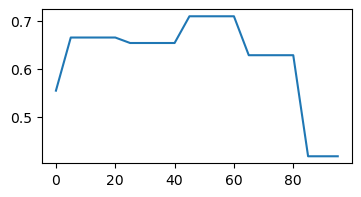

In [97]:
plt.figure(figsize=(4, 2))
plt.plot( range(0, 100, 5), score_list )
plt.show()

In [ ]:
재현율   => 전체 1중에서 우리가 1을 맞춘 비율, 1을 놓치면 큰일 날때
정밀도   => 1이라고 예측한 것 중에서 1을 맞춘 비율, 0을 1이라 말하면 비용이 높을 때
f-score

In [98]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier(class_weight='balanced')

# 비지도 학습
- target 데이터가 없는 경우
- (컴퓨터가 알아서) 데이터를 분류해 줌 => 군집분석
- 차원축소

## 차원축소
- PCA(주성분 분석)

In [103]:
from sklearn.decomposition import PCA

iris_df = sns.load_dataset('iris')
X = iris_df.iloc[:, :-1]
y = iris_df['species']

In [113]:
pca = PCA()
pca.fit(X)
np.cumsum( pca.explained_variance_ratio_ )

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

In [117]:
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)
train_x, valid_x, train_y, valid_y = train_test_split(X2, y, 
                                                      test_size=0.2,
                                                      random_state=18,
                                                      stratify=y)
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)
knn.score(valid_x, valid_y)

0.9666666666666667

## 군집분석
- Kmeans 알고리즘

In [119]:
from sklearn.cluster import KMeans

In [122]:
kmeans = KMeans( n_clusters=3 )
kmeans.fit( iris_df.iloc[:, :4] )

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

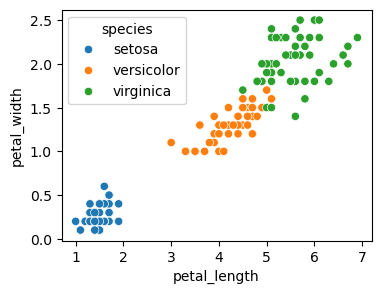

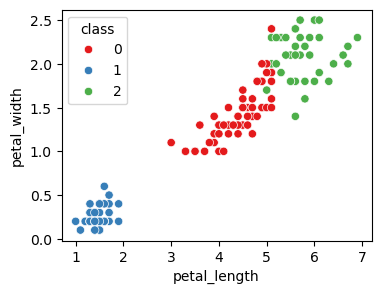

In [131]:
iris_df['class'] = kmeans.predict( iris_df.iloc[:, :4] )

plt.figure(figsize=(4, 3))
sns.scatterplot(iris_df, x='petal_length', y='petal_width', hue='species')
plt.show()

plt.figure(figsize=(4, 3))
sns.scatterplot(iris_df, x='petal_length', y='petal_width', hue='class',
                palette='Set1')
plt.show()

In [ ]:
# 최적의 k를 찾아보자
wcss_list = []
for k in range(1, 16):
    km = KMeans(n_clusters=k)
    km.fit(iris_df.iloc[:, :4])
    wcss_list.append( km.inertia_ ) # WCSS

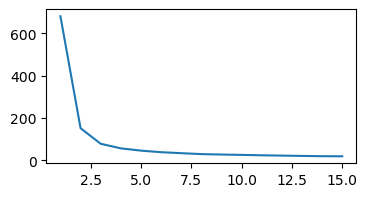

In [136]:
plt.figure(figsize=(4, 2))
plt.plot( range(1, 16), wcss_list )
plt.show()

In [142]:
customer_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\고객설문.csv')
sc = StandardScaler()
X = pd.DataFrame( sc.fit_transform(customer_df), columns=['Satisfication', 'Loyalty'])

In [ ]:
wcss_list = []
for k in range(1, 16):
    km = KMeans(n_clusters=k)
    km.fit(X)
    wcss_list.append( km.inertia_ ) # WCSS

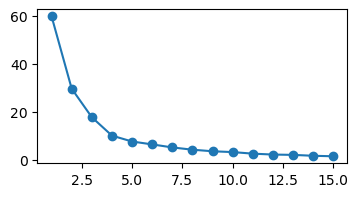

In [146]:
plt.figure(figsize=(4, 2))
plt.plot( range(1, 16), wcss_list, marker='o')
plt.show()

In [ ]:
km = KMeans(n_clusters=4)
km.fit(X)
X['class_4'] = km.predict(X)

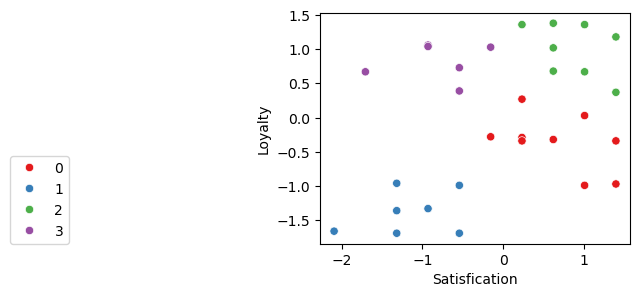

In [152]:
plt.figure(figsize=(4, 3))
sns.scatterplot(X, x='Satisfication', y='Loyalty', hue='class_4',
                palette='Set1')
plt.legend(loc=(-1, 0))
plt.show()